In [5]:
#(1) SetUp Environment

In [1866]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [1868]:
#limit our memory growth(only allocates required memory when running)
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,"True")

In [1871]:
#(2) Data Load

In [1873]:
data_dir = "/Users/norbujamling/Desktop/mydatanew/trial"
image_size = (180,110)

In [1875]:
# List all image files in the directory
file_paths = tf.data.Dataset.list_files(data_dir + '/*.jpg')

# Read and decode images from file paths
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)  # 1 channel for black and white images
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image

# Parse images and create dataset
dataset = file_paths.map(parse_image)

dataset = np.array(list(dataset.as_numpy_iterator()))
# Take only the left half of each image

dataset.shape
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Iterate over the dataset and print the shape of each image
for i, image in enumerate(dataset):
    print(f"Image {i + 1} Shape:", image.shape)

Image 1 Shape: (180, 110, 1)
Image 2 Shape: (180, 110, 1)


2024-06-06 10:02:15.737823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-06 10:02:15.740857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


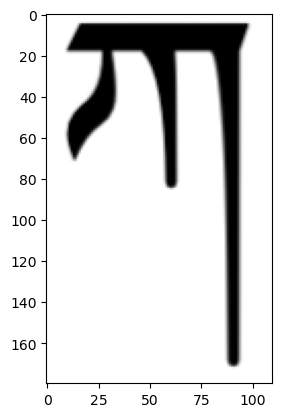

In [1877]:
# Visualize the first image in the dataset
sample_image = next(iter(dataset))
plt.imshow(sample_image[:, :, 0], cmap='gray') 
plt.show()

In [1879]:
# Convert each image to a 1D array
def flatten_image(image):
    return tf.reshape(image, (-1,))

dataset = dataset.map(flatten_image)

# Iterate over the dataset and print the shape of each image
#for i, image in enumerate(dataset):
#    print(f"Image {i + 1} Shape:", image.shape)

In [1881]:
# Reshape each flattened image back to 2D
#def reshape_image(image):
#    return tf.reshape(image, image_size)

#dataset_reshaped = dataset.map(reshape_image)

# Iterate over the dataset and print the shape of each image
#for i, image in enumerate(dataset_reshaped):
#    print(f"Image {i + 1} Shape:", image.shape)

In [1883]:
# Visualize the first image in the reshaped dataset
#sample_image = next(iter(dataset_reshaped))
#plt.imshow(sample_image, cmap='gray') 
#plt.title("Sample Image")
#plt.axis("off")
#plt.show()

In [1885]:
#(3) Build Generator and Discriminator

In [1887]:
latent_dim = 100
input_shape = (180*110,)  # Flattened shape

In [1889]:
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(180*110, activation='sigmoid'))
    return model

In [1891]:
# Build the generator
generator = build_generator(latent_dim)
generator.summary()

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_146 (Dense)               │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_88 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_89 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 19800)          │       653,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,688 (2.51 MB)

 Trainable params: 657,688 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [1893]:
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(16, input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [1895]:
# Build the discriminator
discriminator = build_discriminator(input_shape)
discriminator.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_149 (Dense)               │ (None, 16)             │       316,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_90 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,833 (1.21 MB)

 Trainable params: 316,833 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [1897]:
#(4) Backpropagation

In [1849]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [1851]:
# Training loop
def train_step(images):
    noise = tf.random.normal([1, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [1853]:

dataset_array = np.array(list(dataset.as_numpy_iterator()))

# Set batch size
BATCH_SIZE = 1

# Split the dataset into batches
num_batches = len(dataset_array) // BATCH_SIZE

2024-06-06 10:00:50.390155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1862]:
# Training loop
epochs = 200
for epoch in range(epochs):
    np.random.shuffle(dataset_array)  # Shuffle the dataset at the beginning of each epoch
    for i in range(num_batches):
        batch_images = dataset_array[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        train_step(batch_images)
    print(f'Epoch {epoch+1}/{epochs}')

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


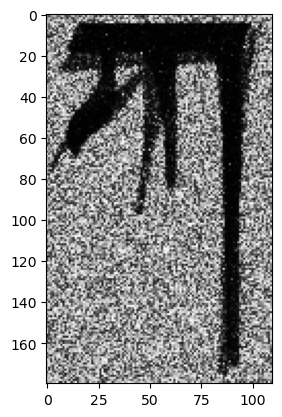

In [1863]:
image_size = (180,110)
imgs = generator.predict(tf.random.normal([2, 100]))[1]
plt.imshow(tf.reshape(imgs, image_size), cmap='gray') 
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


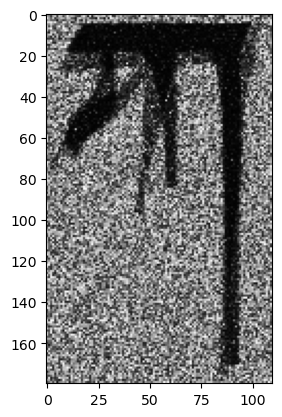

In [1717]:
image_size = (180,110)
imgs = generator.predict(tf.random.normal([2, 100]))[0]
plt.imshow(tf.reshape(imgs, image_size), cmap='gray') 
plt.show()